In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import sys
sys.path.append('../../../src')

from common import common, transform, json
from common.json import TRACKING_FORMAT
from common.keypoint import KeypointsList
from individual_activity.individual_activity import IndividualActivity

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 15

In [15]:
room_num = '09'
date = '20210304'
file_names = [f'pass{i}' for i in range(1, 4)]
names = [f'IA{i}' for i in range(1, 4)]
test_parts = ['RAnkle', 'LAnkle']

In [16]:
def load_keypoints(name):
    tracking_json = os.path.join(
        common.data_dir, '{0}/{1}/{2}/json/tracking.json'.format(room_num, date, name))
    tracking_datas = json.load(tracking_json)
    
    keypoints_dict = {}
    for item in tracking_datas:
        label = item[TRACKING_FORMAT[0]]
        frame_num = item[TRACKING_FORMAT[1]]
        keypoints = np.array(item[TRACKING_FORMAT[2]])
        
        if label not in keypoints_dict:
            keypoints_dict[label] = KeypointsList()
        keypoints_list = keypoints_dict[label]
        
        keypoints_list.append(keypoints)
            
    return keypoints_dict

In [17]:
keypoints_data = {}
for name, file_name in zip(names, file_names):
    keypoints_data[name] = load_keypoints(file_name)

# ABE2021 Reviewer1 Point1

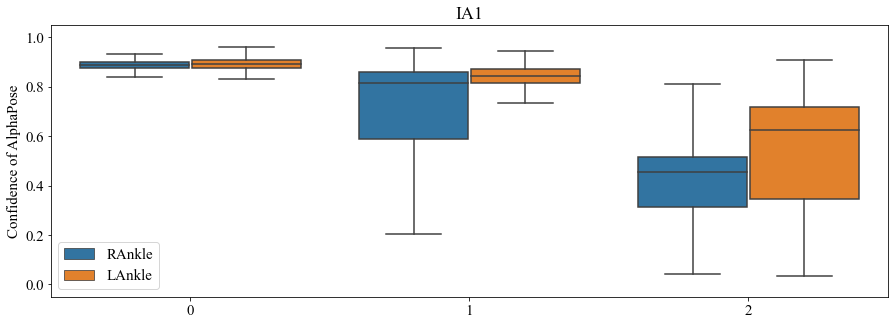

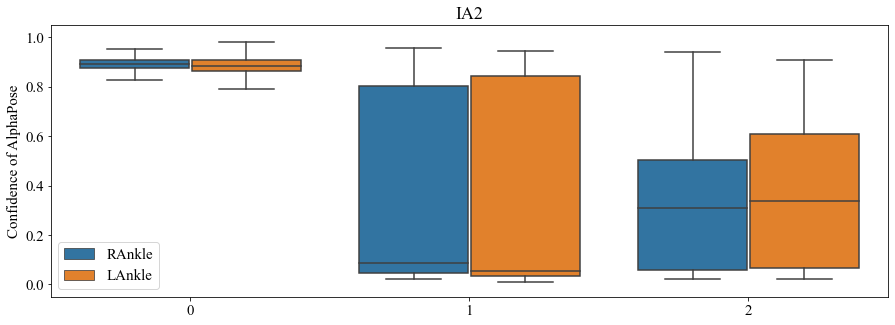

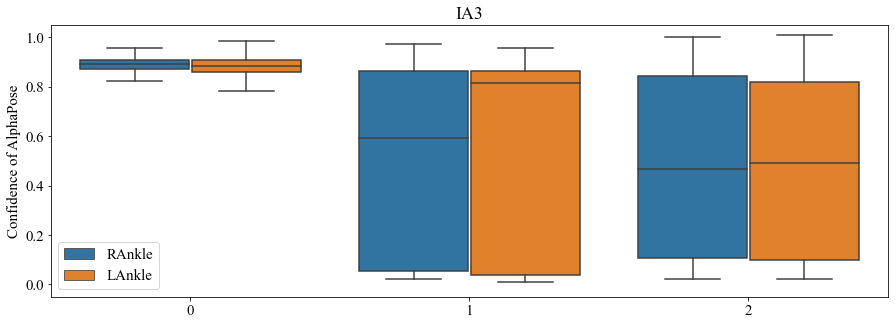

In [18]:
df_lst = []
for name in names:
    keypoints_dict = keypoints_data[name]
    for part in test_parts:
        # 体のパーツごとに信頼度を計算する
        conf_dict = {}
        max_conf_len = 0
        for label in range(3):
            keypoints_list = keypoints_dict[label]

            if label not in conf_dict:
                conf_dict[label] = []
            confs = conf_dict[label]

            for keypoints in keypoints_list:
                # keypointsから信頼度のみ取得
                conf = keypoints.get(part)[2]
                confs.append(conf)

            if len(confs) > max_conf_len:
                max_conf_len = len(confs)

        # 配列が全て同じ長さになるようにNoneでパディング
        for confs in conf_dict.values():
            confs += [None for _ in range(max_conf_len - len(confs))]

        # https://stats.biopapyrus.jp/python/boxplot.html
        df = pd.DataFrame.from_dict(conf_dict)
        df = pd.melt(df)
        df['part'] = part
        df_lst.append(df)

    df = pd.concat(df_lst, axis=0)

    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1)
    sns.boxplot(x='variable', y='value', hue='part', showfliers=False, data=df, ax=ax)
    plt.title(name)
    plt.xlabel('')
    plt.ylabel('Confidence of AlphaPose')
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.savefig(f'../images/ia_boxplot.pdf')
    plt.show()

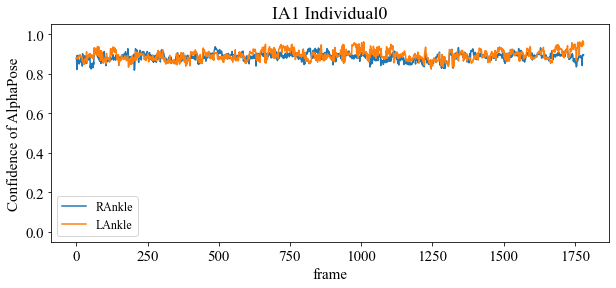

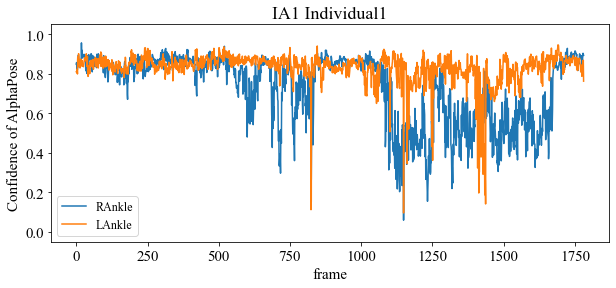

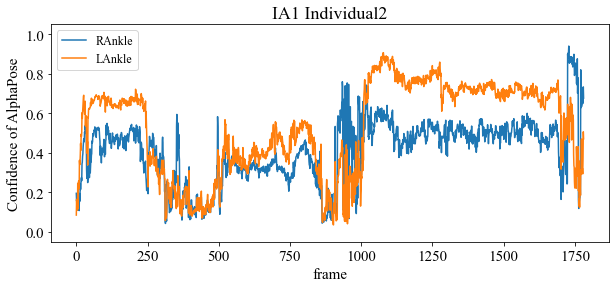

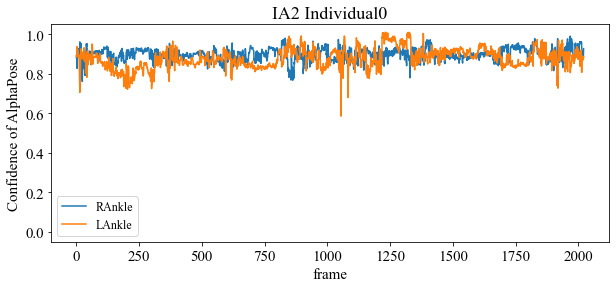

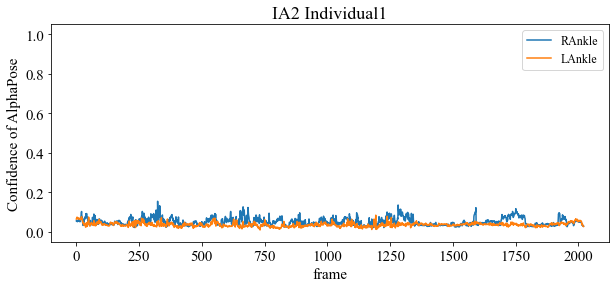

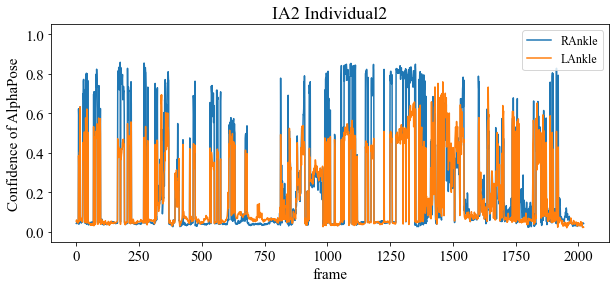

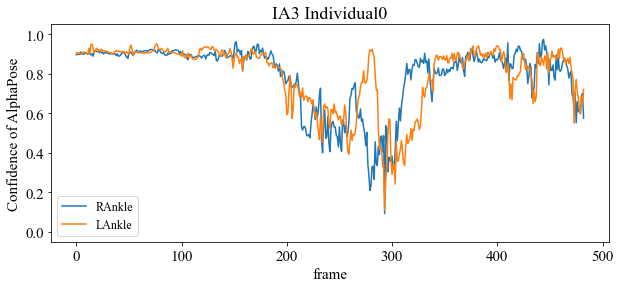

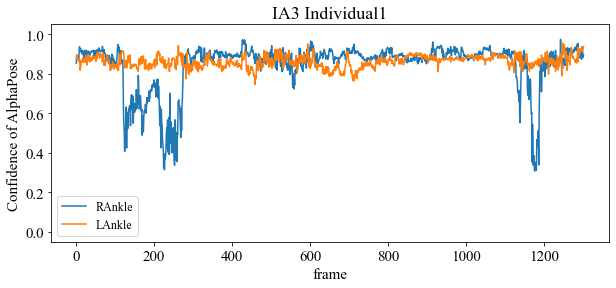

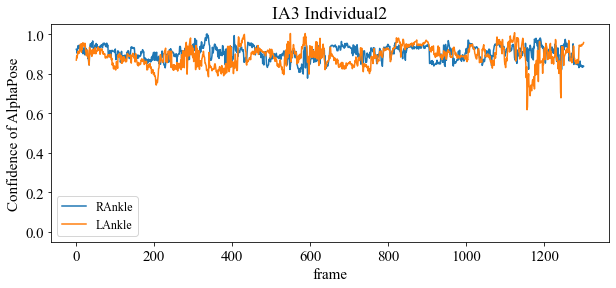

In [19]:
df_lst = []
for name in names:
    keypoints_dict = keypoints_data[name]
    
    for label in range(3):
        keypoints_list = keypoints_dict[label]
        
        conf_dict = {part:[] for part in test_parts}
        for part in test_parts:
            confs = conf_dict[part]
            
            for keypoints in keypoints_list:
                confs.append(keypoints.get(part)[2])

        df = pd.DataFrame.from_dict(conf_dict)
        
        fig = plt.figure(figsize=(10, 4))
        ax = fig.add_subplot(1, 1, 1)
        df.plot(ax=ax)
        plt.title(f'{name} Individual{label}')
        plt.xlabel('frame')
        plt.ylabel('Confidence of AlphaPose')
        plt.ylim(-0.05, 1.05)
        plt.legend(prop={'size':12})
        
        plt.savefig(f'../images/{name}-{label}.pdf')
        plt.show()